In [337]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [338]:
DATASET_PATH = 'data/mini_speech_commands'
data_dir = pathlib.Path(DATASET_PATH)
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)

Commands: ['Bom Kanan' 'Bom Kiri' 'Hidup' 'Jalan Kanan' 'Jalan Kiri' 'Lompat'
 'Lompat Kanan' 'Lompat Kiri' 'Nunduk' 'Nunduk Tembak' 'Tembak'
 'Tembak Atas' 'Tembak Kiri']


In [339]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 39
Number of examples per label: 3
Example file tensor: tf.Tensor(b'data\\mini_speech_commands\\Jalan Kanan\\Kanan.wav', shape=(), dtype=string)


In [340]:
train_files = filenames[:6400]
val_files = filenames
test_files = filenames[-800:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 39
Validation set size 39
Test set size 39


In [341]:
test_file = tf.io.read_file(DATASET_PATH+'/Bom Kanan/Bom Kanan.wav')
test_audio, _ = tf.audio.decode_wav(contents=test_file)
test_audio.shape

TensorShape([52736, 2])

In [342]:
def decode_audio(audio_binary):
  # Decode WAV-encoded audio files to `float32` tensors, normalized
  # to the [-1.0, 1.0] range. Return `float32` audio and a sample rate.
  audio, _ = tf.audio.decode_wav(contents=audio_binary, desired_channels=1)
  # Since all the data is single channel (mono), drop the `channels`
  # axis from the array.
  return tf.squeeze(audio, axis=-1)

In [343]:
def get_label(file_path):
  parts = tf.strings.split(
      input=file_path,
      sep=os.path.sep)
  # Note: You'll use indexing here instead of tuple unpacking to enable this
  # to work in a TensorFlow graph.
  return parts[-2]

In [344]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

In [345]:
AUTOTUNE = tf.data.AUTOTUNE

files_ds = tf.data.Dataset.from_tensor_slices(train_files)

waveform_ds = files_ds.map(
    map_func=get_waveform_and_label,
    num_parallel_calls=AUTOTUNE)

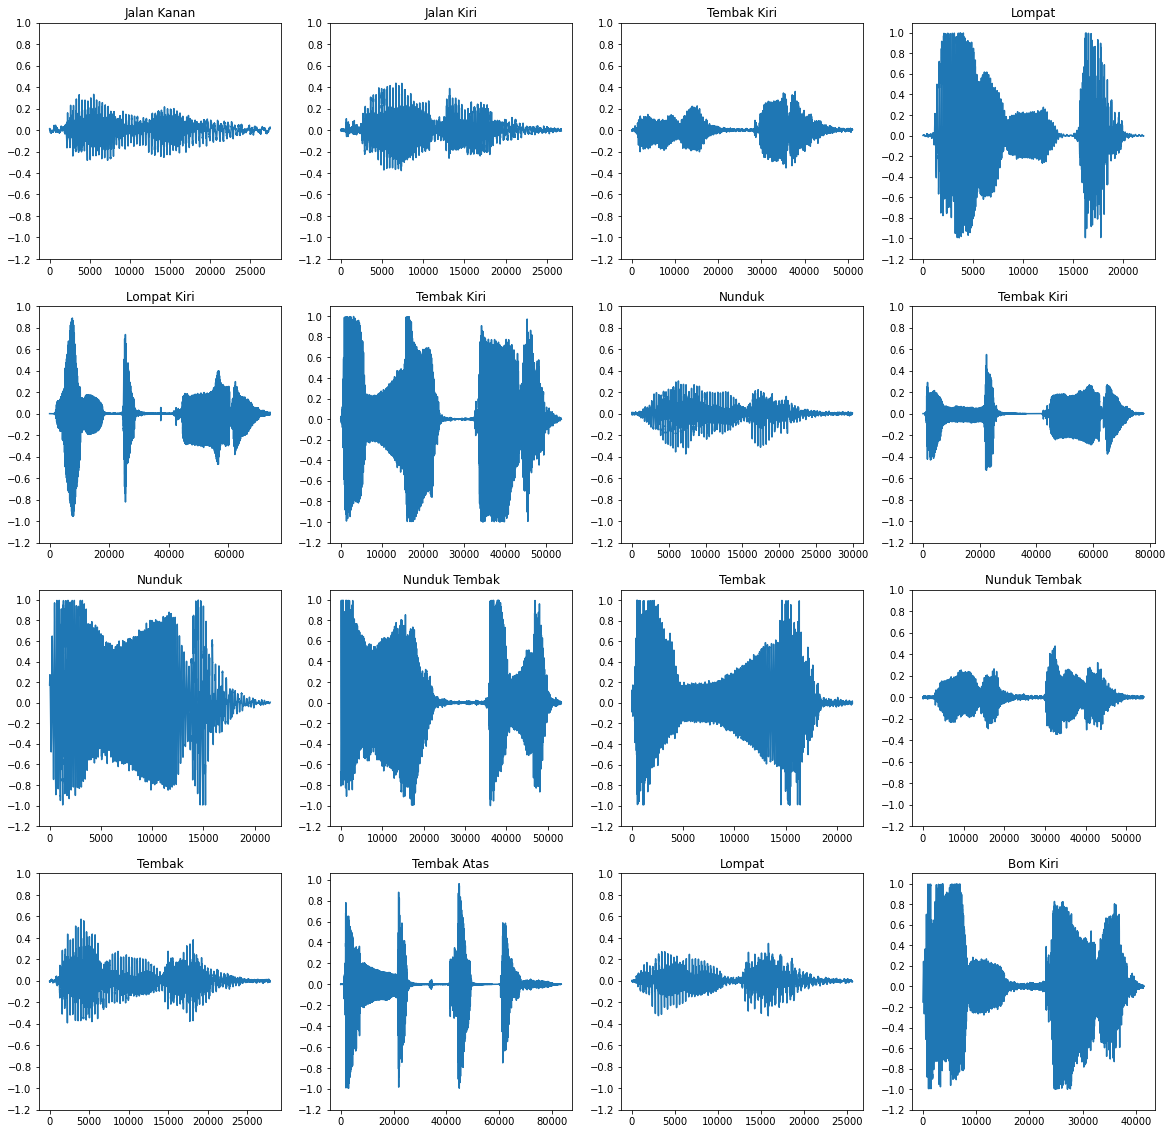

In [346]:
rows = 4
cols = 4
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(20, 20))

for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

In [347]:
def get_spectrogram(waveform):
  # Zero-padding for an audio waveform with less than 16,000 samples.
  input_len = 16000
  waveform = waveform[:input_len]
  zero_padding = tf.zeros(
      [16000] - tf.shape(waveform),
      dtype=tf.float32)
  # Cast the waveform tensors' dtype to float32.
  waveform = tf.cast(waveform, dtype=tf.float32)
  # Concatenate the waveform with `zero_padding`, which ensures all audio
  # clips are of the same length.
  equal_length = tf.concat([waveform, zero_padding], 0)
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [348]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: Jalan Kanan
Waveform shape: (27520,)
Spectrogram shape: (124, 129, 1)
Audio playback


In [349]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

C:\Users\Asus\AppData\Local\Temp/ipykernel_15048/3600643975.py:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(X, Y, log_spec)


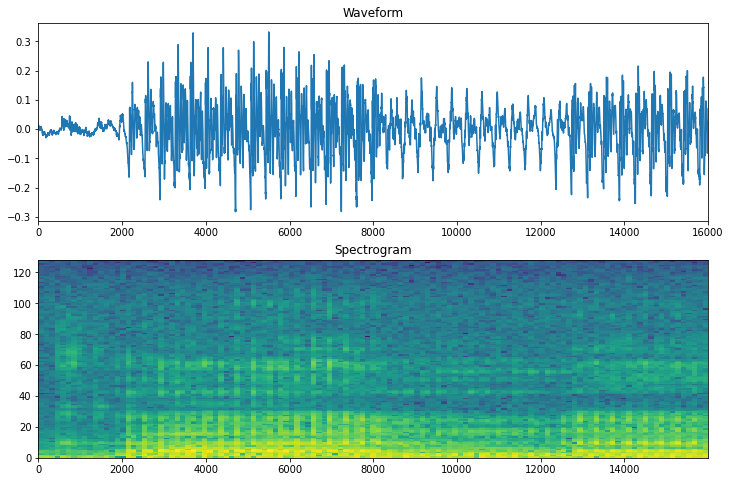

In [350]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [351]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  label_id = tf.argmax(label == commands)
  return spectrogram, label_id

In [352]:
spectrogram_ds = waveform_ds.map(
  map_func=get_spectrogram_and_label_id,
  num_parallel_calls=AUTOTUNE)

C:\Users\Asus\AppData\Local\Temp/ipykernel_15048/3600643975.py:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(X, Y, log_spec)


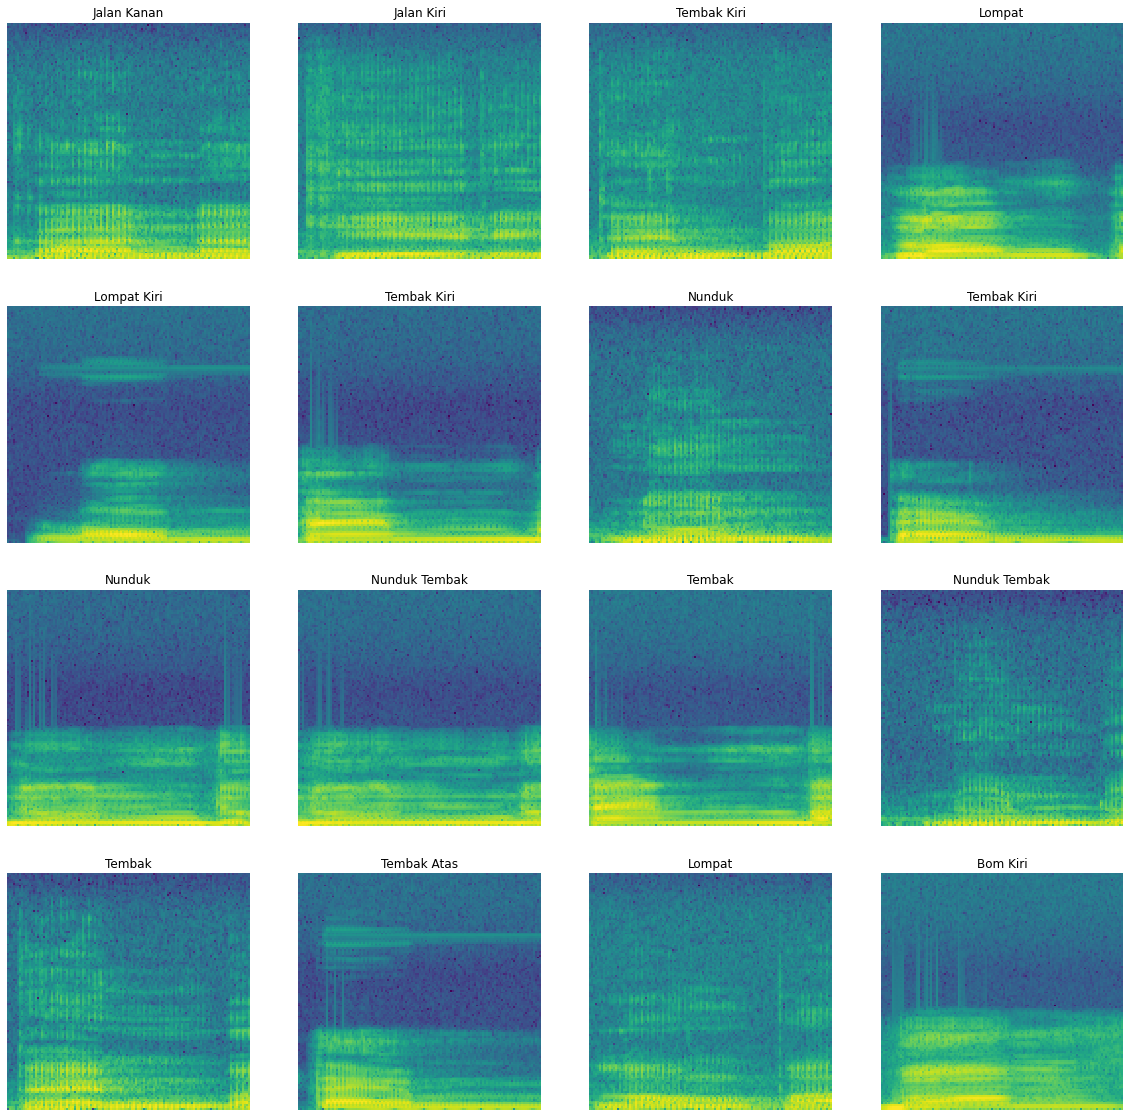

In [353]:
rows = 4
cols = 4
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(20, 20))

for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(spectrogram.numpy(), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')

plt.show()

In [354]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(
      map_func=get_waveform_and_label,
      num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      map_func=get_spectrogram_and_label_id,
      num_parallel_calls=AUTOTUNE)
  return output_ds

In [392]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

In [393]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [394]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [395]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)
Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_21 (Resizing)       (None, 32, 32, 1)         0         
_________________________________________________________________
normalization_23 (Normalizat (None, 32, 32, 1)         3         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_42 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_21 (Flatten)      

In [396]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [397]:
EPOCHS = 50
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/50
1/1 [==============================] - 1s 721ms/step - loss: 2.5768 - accuracy: 0.1026 - val_loss: 2.5259 - val_accuracy: 0.1282
Epoch 2/50
1/1 [==============================] - 0s 118ms/step - loss: 2.5017 - accuracy: 0.1282 - val_loss: 2.4661 - val_accuracy: 0.2821
Epoch 3/50
1/1 [==============================] - 0s 135ms/step - loss: 2.4851 - accuracy: 0.2308 - val_loss: 2.3940 - val_accuracy: 0.3590
Epoch 4/50
1/1 [==============================] - 0s 143ms/step - loss: 2.5165 - accuracy: 0.1795 - val_loss: 2.3206 - val_accuracy: 0.3590
Epoch 5/50
1/1 [==============================] - 0s 132ms/step - loss: 2.3796 - accuracy: 0.2308 - val_loss: 2.2519 - val_accuracy: 0.4103
Epoch 6/50
1/1 [==============================] - 0s 140ms/step - loss: 2.2161 - accuracy: 0.3333 - val_loss: 2.1791 - val_accuracy: 0.4359
Epoch 7/50
1/1 [==============================] - 0s 142ms/step - loss: 2.1777 - accuracy: 0.3333 - val_loss: 2.0983 - val_accuracy: 0.4103
Epoch 8/50
1/1 [====

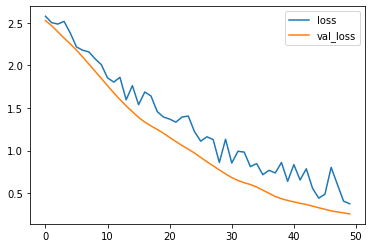

In [398]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [399]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [400]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 100%


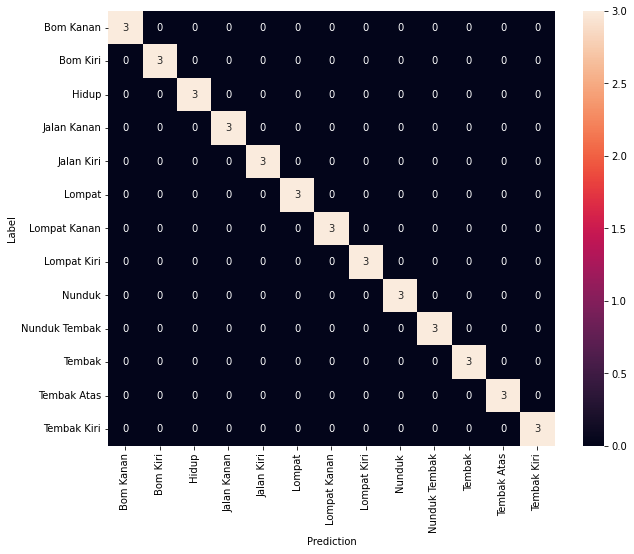

In [401]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

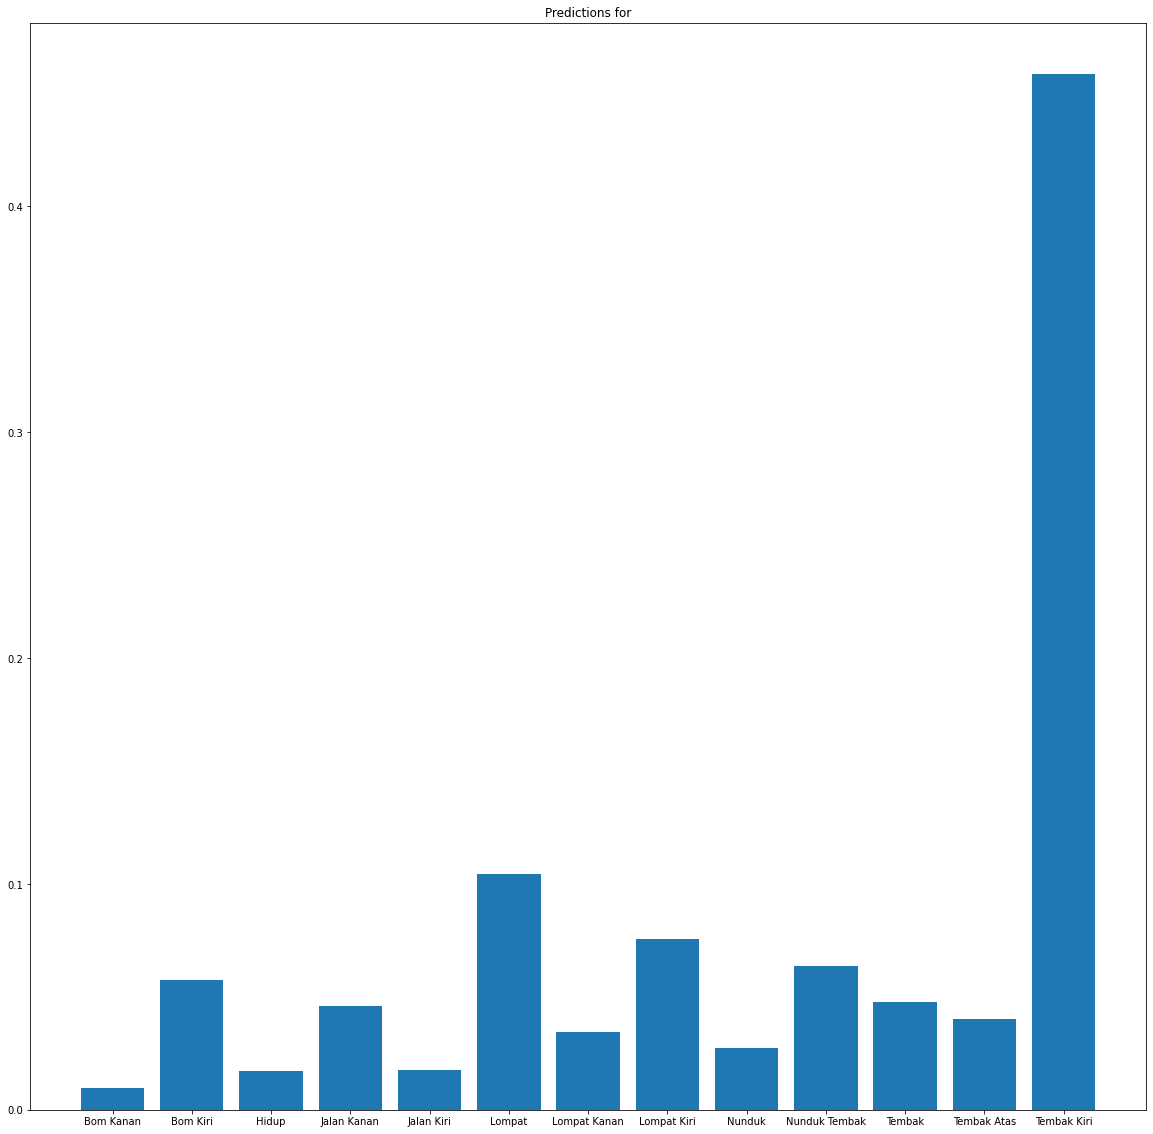

In [402]:
sample_file = data_dir/'z/Tembak Kiri.wav'

sample_ds = preprocess_dataset([str(sample_file)])
plt.figure(figsize=(20,20))
for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title('Predictions for')
  plt.show()

In [403]:
print(max(tf.nn.softmax(prediction)))

tf.Tensor(
[0.00977498 0.05731685 0.01734283 0.04599754 0.01770923 0.10427799
 0.03445752 0.07572757 0.02716094 0.06356958 0.04794428 0.04030833
 0.45841232], shape=(13,), dtype=float32)
